##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Predict house prices: regression

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/basic_regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/models/blob/master/samples/core/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/models/blob/master/samples/core/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to predict a discrete label (for example, where a picture contains an apple or an orange). 

This notebook builds a model to predict the median price of homes in a Boston suburb during the mid-1970s. To do this, we'll provide the model with some data points about the suburb, such as the crime rate and the local property tax rate.

This example uses the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [3]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.11.0-dev20180806


## The Boston Housing Prices dataset

This [dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) is accessible directly in TensorFlow. Download and shuffle the training set:

In [4]:
boston_housing = keras.datasets.boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

57344/57026 [==============================] - 0s 4us/step


In [11]:
# Shuffle the training set. Why? See https://stats.stackexchange.com/a/311327/167299
shuffled_train_labels = np.random.random(train_labels.shape)
print(shuffled_train_labels[:5])

shuffled_resorted_indices = np.argsort(shuffled_train_labels)
print(shuffled_resorted_indices[:5])

train_data = train_data[shuffled_resorted_indices]
train_labels = train_labels[shuffled_resorted_indices]

[0.24242501 0.97240311 0.05449331 0.28095367 0.22825535]
[  9 202 193  63 356]


### Examples and features 

This dataset is much smaller than the others we've worked with so far: it has 506 total examples are split between 404 training examples and 102 test examples:

In [14]:
print("Training set: number examples = {}, number features = {}"
      .format(train_data.shape[0], train_data.shape[1]))
print("Testing set: number examples = {}, number features = {}"
      .format(test_data.shape[0], test_data.shape[1]))

assert train_data.shape[1] == test_data.shape[1], 'feature count mismatch between training and testing datasets'

Training set: number examples = 404, number features = 13
Testing set: number examples = 102, number features = 13


The dataset contains 13 different features:

1.   Per capita crime rate.
2.   The proportion of residential land zoned for lots over 25,000 square feet.
3.   The proportion of non-retail business acres per town.
4.   Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5.   Nitric oxides concentration (parts per 10 million).
6.   The average number of rooms per dwelling.
7.   The proportion of owner-occupied units built before 1940.
8.   Weighted distances to five Boston employment centers.
9.   Index of accessibility to radial highways.
10.  Full-value property-tax rate per $10,000.
11.  Pupil-teacher ratio by town.
12.  1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13.  Percentage lower status of the population.

Each one of these input data features is stored using a different scale. Some features are represented by a proportion between 0 and 1, other features are ranges between 1 and 12, some are ranges between 0 and 100, and so on. This is often the case with real-world data, and understanding how to explore and clean such data is an important skill to develop.

Key Point: As a modeler and developer, think about how this data is used and the potential benefits and harm a model's predictions can cause. A model like this could reinforce societal biases and disparities. **Is a feature relevant to the problem you want to solve or will it introduce bias?** For more information, read about [ML fairness](https://developers.google.com/machine-learning/fairness-overview/).

In [15]:
print(train_data[0])  # Display sample features, notice the different scales

[4.3790e-02 8.0000e+01 3.3700e+00 0.0000e+00 3.9800e-01 5.7870e+00
 3.1100e+01 6.6115e+00 4.0000e+00 3.3700e+02 1.6100e+01 3.9690e+02
 1.0240e+01]


Use the [pandas](https://pandas.pydata.org) library to display the first few rows of the dataset in a nicely formatted table:

In [16]:
import pandas as pd

column_names = ['CRIM', 'ZN', 'INDUS', 
                'CHAS', 'NOX', 'RM', 'AGE', 
                'DIS', 'RAD', 'TAX', 
                'PTRATIO', 'B', 'LSTAT']

df = pd.DataFrame(train_data, columns=column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.04379,80.0,3.37,0.0,0.398,5.787,31.1,6.6115,4.0,337.0,16.1,396.90,10.24
1,0.06899,0.0,25.65,0.0,0.581,5.870,69.7,2.2577,2.0,188.0,19.1,389.15,14.37
2,2.37857,0.0,18.10,0.0,0.583,5.871,41.9,3.7240,24.0,666.0,20.2,370.73,13.34
3,0.12269,0.0,6.91,0.0,0.448,6.069,40.0,5.7209,3.0,233.0,17.9,389.39,9.55
4,0.24103,0.0,7.38,0.0,0.493,6.083,43.7,5.4159,5.0,287.0,19.6,396.90,12.79


### Labels

The labels are the house prices in thousands of dollars. (You may notice the mid-1970s prices.)

In [18]:
print(train_labels[:10])  # Display first 10 entries

[19.4 22.  20.6 21.2 22.2 17.5 13.4 21.7 32.  20.3]


## Normalize features

It's recommended to normalize features that use different scales and ranges. For each feature, subtract the mean of the feature and divide by the standard deviation:

In [21]:
# Test data is *not* used when calculating the mean and std.

total_samples_features_means_vect = train_data.mean(axis=0)
print(total_samples_features_means_vect)
total_samples_features_stds_vect = train_data.std(axis=0)
print(total_samples_features_stds_vect)

[3.74511057e+00 1.14801980e+01 1.11044307e+01 6.18811881e-02
 5.57355941e-01 6.26708168e+00 6.90106436e+01 3.74027079e+00
 9.44059406e+00 4.05898515e+02 1.84759901e+01 3.54783168e+02
 1.27408168e+01]
[9.22929073e+00 2.37382770e+01 6.80287253e+00 2.40939633e-01
 1.17147847e-01 7.08908627e-01 2.79060634e+01 2.02770050e+00
 8.68758849e+00 1.66168506e+02 2.19765689e+00 9.39946015e+01
 7.24556085e+00]


In [22]:
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

print(train_data[0])  # First training sample, normalized

[-0.40104063  2.88646905 -1.136936   -0.25683275 -1.36029765 -0.67721236
 -1.35850919  1.41600261 -0.62624905 -0.4146304  -1.08114698  0.44807713
 -0.34515159]


Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model more dependant on the choice of units used in the input.

## Create the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [59]:
NUM_FEATURES = train_data.shape[1]

def build_model():
    """ return compiled NN model """
    single_output_layer = keras.layers.Dense(1)
    model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(NUM_FEATURES,)),
        keras.layers.Dense(64, activation=tf.nn.relu),
        single_output_layer
    ])

    optimizer = tf.train.RMSPropOptimizer(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae'])
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 64)                896       
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


## Train the model

The model is trained for 500 epochs, and record the training and validation accuracy in the `history` object.

In [60]:
# keras Callback to display training progress by printing a single dot for each completed epoch.
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(train_data, train_labels, 
                    epochs=EPOCHS,
                    validation_split=0.2, 
                    verbose=1,
                    callbacks=[PrintDot()])

Train on 323 samples, validate on 81 samples
Epoch 1/500
323/323 [==============================] - 0s 975us/step - loss: 586.2111 - mean_absolute_error: 22.4309 - val_loss: 485.1308 - val_mean_absolute_error: 19.8913

.Epoch 2/500
323/323 [==============================] - 0s 48us/step - loss: 534.6953 - mean_absolute_error: 21.3034 - val_loss: 434.3711 - val_mean_absolute_error: 18.5674
.Epoch 3/500
323/323 [==============================] - 0s 63us/step - loss: 479.1966 - mean_absolute_error: 19.9860 - val_loss: 385.3788 - val_mean_absolute_error: 17.1364
.Epoch 4/500
323/323 [==============================] - 0s 64us/step - loss: 419.3865 - mean_absolute_error: 18.4658 - val_loss: 322.1897 - val_mean_absolute_error: 15.3710
.Epoch 5/500
323/323 [==============================] - 0s 60us/step - loss: 344.4466 - mean_absolute_error: 16.4843 - val_loss: 256.8981 - val_mean_absolute_error: 13.3286
.Epoch 6/500
323/323 [==============================] - 0s 61us/step - loss: 265.9893 - m

.Epoch 49/500
323/323 [==============================] - 0s 56us/step - loss: 9.2072 - mean_absolute_error: 2.1861 - val_loss: 13.4157 - val_mean_absolute_error: 2.4730
.Epoch 50/500
323/323 [==============================] - 0s 54us/step - loss: 8.7881 - mean_absolute_error: 2.1010 - val_loss: 13.6815 - val_mean_absolute_error: 2.5137
.Epoch 51/500
323/323 [==============================] - 0s 48us/step - loss: 8.6198 - mean_absolute_error: 2.0832 - val_loss: 13.4562 - val_mean_absolute_error: 2.6084
.Epoch 52/500
323/323 [==============================] - 0s 51us/step - loss: 9.0398 - mean_absolute_error: 2.1477 - val_loss: 14.1044 - val_mean_absolute_error: 2.7735
.Epoch 53/500
323/323 [==============================] - 0s 53us/step - loss: 8.7952 - mean_absolute_error: 2.1094 - val_loss: 13.5603 - val_mean_absolute_error: 2.4574
.Epoch 54/500
323/323 [==============================] - 0s 54us/step - loss: 8.7333 - mean_absolute_error: 2.0684 - val_loss: 14.6575 - val_mean_absolute_

323/323 [==============================] - 0s 56us/step - loss: 6.8408 - mean_absolute_error: 1.8595 - val_loss: 11.5044 - val_mean_absolute_error: 2.4717
.Epoch 98/500
323/323 [==============================] - 0s 58us/step - loss: 6.5718 - mean_absolute_error: 1.8174 - val_loss: 12.4830 - val_mean_absolute_error: 2.6923
.Epoch 99/500
323/323 [==============================] - 0s 45us/step - loss: 6.4729 - mean_absolute_error: 1.8207 - val_loss: 11.1844 - val_mean_absolute_error: 2.4143
.Epoch 100/500
323/323 [==============================] - 0s 51us/step - loss: 6.4636 - mean_absolute_error: 1.7857 - val_loss: 11.0636 - val_mean_absolute_error: 2.3993
.Epoch 101/500
323/323 [==============================] - 0s 54us/step - loss: 6.6304 - mean_absolute_error: 1.8227 - val_loss: 11.5929 - val_mean_absolute_error: 2.3451

.Epoch 102/500
323/323 [==============================] - 0s 54us/step - loss: 6.1978 - mean_absolute_error: 1.7770 - val_loss: 11.0923 - val_mean_absolute_error: 2.3

323/323 [==============================] - 0s 64us/step - loss: 5.3415 - mean_absolute_error: 1.6300 - val_loss: 10.5036 - val_mean_absolute_error: 2.3842
.Epoch 146/500
323/323 [==============================] - 0s 65us/step - loss: 5.2890 - mean_absolute_error: 1.6339 - val_loss: 10.2606 - val_mean_absolute_error: 2.3264
.Epoch 147/500
323/323 [==============================] - 0s 52us/step - loss: 5.2180 - mean_absolute_error: 1.5856 - val_loss: 10.6009 - val_mean_absolute_error: 2.3141
.Epoch 148/500
323/323 [==============================] - 0s 58us/step - loss: 5.1889 - mean_absolute_error: 1.5657 - val_loss: 11.6203 - val_mean_absolute_error: 2.5435
.Epoch 149/500
323/323 [==============================] - 0s 53us/step - loss: 5.2194 - mean_absolute_error: 1.5963 - val_loss: 11.0082 - val_mean_absolute_error: 2.3816
.Epoch 150/500
323/323 [==============================] - 0s 51us/step - loss: 5.3106 - mean_absolute_error: 1.6270 - val_loss: 10.2740 - val_mean_absolute_error: 2.

323/323 [==============================] - 0s 51us/step - loss: 4.6201 - mean_absolute_error: 1.4964 - val_loss: 12.0090 - val_mean_absolute_error: 2.6573
.Epoch 194/500
323/323 [==============================] - 0s 55us/step - loss: 4.3739 - mean_absolute_error: 1.4788 - val_loss: 9.9759 - val_mean_absolute_error: 2.3195
.Epoch 195/500
323/323 [==============================] - 0s 57us/step - loss: 4.4301 - mean_absolute_error: 1.4733 - val_loss: 10.3757 - val_mean_absolute_error: 2.3267
.Epoch 196/500
323/323 [==============================] - 0s 61us/step - loss: 4.2978 - mean_absolute_error: 1.4820 - val_loss: 10.3446 - val_mean_absolute_error: 2.4190
.Epoch 197/500
323/323 [==============================] - 0s 58us/step - loss: 4.3554 - mean_absolute_error: 1.4483 - val_loss: 11.1694 - val_mean_absolute_error: 2.5042
.Epoch 198/500
323/323 [==============================] - 0s 49us/step - loss: 4.4132 - mean_absolute_error: 1.4820 - val_loss: 10.1422 - val_mean_absolute_error: 2.3

323/323 [==============================] - 0s 50us/step - loss: 3.6999 - mean_absolute_error: 1.3554 - val_loss: 11.0877 - val_mean_absolute_error: 2.4480
.Epoch 242/500
323/323 [==============================] - 0s 51us/step - loss: 3.6500 - mean_absolute_error: 1.3668 - val_loss: 11.1046 - val_mean_absolute_error: 2.5129
.Epoch 243/500
323/323 [==============================] - 0s 51us/step - loss: 3.8049 - mean_absolute_error: 1.4071 - val_loss: 10.5283 - val_mean_absolute_error: 2.4397
.Epoch 244/500
323/323 [==============================] - 0s 53us/step - loss: 3.4380 - mean_absolute_error: 1.3059 - val_loss: 10.8977 - val_mean_absolute_error: 2.4650
.Epoch 245/500
323/323 [==============================] - 0s 53us/step - loss: 3.7439 - mean_absolute_error: 1.3840 - val_loss: 10.6022 - val_mean_absolute_error: 2.4502
.Epoch 246/500
323/323 [==============================] - 0s 52us/step - loss: 3.6536 - mean_absolute_error: 1.3418 - val_loss: 11.9368 - val_mean_absolute_error: 2.

323/323 [==============================] - 0s 56us/step - loss: 3.0975 - mean_absolute_error: 1.2547 - val_loss: 12.4341 - val_mean_absolute_error: 2.7068
.Epoch 290/500
323/323 [==============================] - 0s 57us/step - loss: 3.3588 - mean_absolute_error: 1.3285 - val_loss: 11.0624 - val_mean_absolute_error: 2.5003
.Epoch 291/500
323/323 [==============================] - 0s 53us/step - loss: 3.1228 - mean_absolute_error: 1.2701 - val_loss: 10.4907 - val_mean_absolute_error: 2.4246
.Epoch 292/500
323/323 [==============================] - 0s 55us/step - loss: 3.1405 - mean_absolute_error: 1.2639 - val_loss: 12.3967 - val_mean_absolute_error: 2.6200
.Epoch 293/500
323/323 [==============================] - 0s 52us/step - loss: 3.2441 - mean_absolute_error: 1.2886 - val_loss: 10.2623 - val_mean_absolute_error: 2.4128
.Epoch 294/500
323/323 [==============================] - 0s 52us/step - loss: 3.1502 - mean_absolute_error: 1.2643 - val_loss: 10.7864 - val_mean_absolute_error: 2.

323/323 [==============================] - 0s 53us/step - loss: 2.6424 - mean_absolute_error: 1.1651 - val_loss: 10.3558 - val_mean_absolute_error: 2.3809
.Epoch 338/500
323/323 [==============================] - 0s 53us/step - loss: 2.7746 - mean_absolute_error: 1.2042 - val_loss: 10.2488 - val_mean_absolute_error: 2.3522
.Epoch 339/500
323/323 [==============================] - 0s 52us/step - loss: 2.4995 - mean_absolute_error: 1.1530 - val_loss: 10.0636 - val_mean_absolute_error: 2.3738
.Epoch 340/500
323/323 [==============================] - 0s 54us/step - loss: 2.7372 - mean_absolute_error: 1.1992 - val_loss: 10.0344 - val_mean_absolute_error: 2.3460
.Epoch 341/500
323/323 [==============================] - 0s 52us/step - loss: 2.4944 - mean_absolute_error: 1.1628 - val_loss: 10.9135 - val_mean_absolute_error: 2.4659
.Epoch 342/500
323/323 [==============================] - 0s 53us/step - loss: 2.7268 - mean_absolute_error: 1.1808 - val_loss: 10.4291 - val_mean_absolute_error: 2.

323/323 [==============================] - 0s 60us/step - loss: 2.3794 - mean_absolute_error: 1.1327 - val_loss: 10.4256 - val_mean_absolute_error: 2.4242
.Epoch 386/500
323/323 [==============================] - 0s 64us/step - loss: 2.1344 - mean_absolute_error: 1.0708 - val_loss: 10.5915 - val_mean_absolute_error: 2.4666
.Epoch 387/500
323/323 [==============================] - 0s 63us/step - loss: 2.2395 - mean_absolute_error: 1.0887 - val_loss: 10.1749 - val_mean_absolute_error: 2.3422
.Epoch 388/500
323/323 [==============================] - 0s 69us/step - loss: 2.1093 - mean_absolute_error: 1.0555 - val_loss: 11.6904 - val_mean_absolute_error: 2.5784
.Epoch 389/500
323/323 [==============================] - 0s 63us/step - loss: 2.1644 - mean_absolute_error: 1.0754 - val_loss: 10.7412 - val_mean_absolute_error: 2.4161
.Epoch 390/500
323/323 [==============================] - 0s 60us/step - loss: 2.2715 - mean_absolute_error: 1.1003 - val_loss: 10.5165 - val_mean_absolute_error: 2.

323/323 [==============================] - 0s 60us/step - loss: 1.9325 - mean_absolute_error: 1.0182 - val_loss: 11.2556 - val_mean_absolute_error: 2.4937
.Epoch 434/500
323/323 [==============================] - 0s 71us/step - loss: 1.9436 - mean_absolute_error: 1.0372 - val_loss: 11.7886 - val_mean_absolute_error: 2.6204
.Epoch 435/500
323/323 [==============================] - 0s 59us/step - loss: 2.1715 - mean_absolute_error: 1.0835 - val_loss: 10.3886 - val_mean_absolute_error: 2.4505
.Epoch 436/500
323/323 [==============================] - 0s 70us/step - loss: 2.0020 - mean_absolute_error: 1.0315 - val_loss: 10.2298 - val_mean_absolute_error: 2.3907
.Epoch 437/500
323/323 [==============================] - 0s 77us/step - loss: 1.7927 - mean_absolute_error: 0.9924 - val_loss: 12.1059 - val_mean_absolute_error: 2.5674
.Epoch 438/500
323/323 [==============================] - 0s 57us/step - loss: 1.9707 - mean_absolute_error: 0.9952 - val_loss: 11.0857 - val_mean_absolute_error: 2.

323/323 [==============================] - 0s 56us/step - loss: 1.6440 - mean_absolute_error: 0.9454 - val_loss: 12.1451 - val_mean_absolute_error: 2.5682
.Epoch 482/500
323/323 [==============================] - 0s 54us/step - loss: 1.5792 - mean_absolute_error: 0.9218 - val_loss: 10.9245 - val_mean_absolute_error: 2.5221
.Epoch 483/500
323/323 [==============================] - 0s 50us/step - loss: 1.6111 - mean_absolute_error: 0.9412 - val_loss: 10.9496 - val_mean_absolute_error: 2.4845
.Epoch 484/500
323/323 [==============================] - 0s 61us/step - loss: 1.7264 - mean_absolute_error: 0.9287 - val_loss: 10.8328 - val_mean_absolute_error: 2.4812
.Epoch 485/500
323/323 [==============================] - 0s 51us/step - loss: 1.5529 - mean_absolute_error: 0.8748 - val_loss: 12.6836 - val_mean_absolute_error: 2.6622
.Epoch 486/500
323/323 [==============================] - 0s 54us/step - loss: 2.0149 - mean_absolute_error: 1.0195 - val_loss: 12.5343 - val_mean_absolute_error: 2.

Visualize the model's training progress using the stats stored in the `history` object. We want to use this data to determine how long to train *before* the model stops making progress.

In [61]:
print(history)
print(history.history.keys())
print(history.epoch[:5])
print(history.history['mean_absolute_error'][:5])

assert len(history.epoch) == len(history.history['mean_absolute_error']) \
        and len(history.epoch) == len(history.history['val_mean_absolute_error']) \
        and len(history.epoch) == len(history.history['val_loss']), \
        'Some epochs appear to have no history values recorded'

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])
[0, 1, 2, 3, 4]
[22.430874851096895, 21.303448101315336, 19.98601937072565, 18.465837248338634, 16.484340148075447]


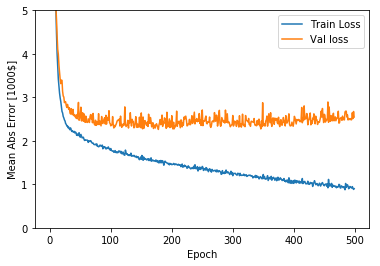

In [62]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')

    train_x, train_y = history.epoch, np.array(history.history['mean_absolute_error'])
    plt.plot(train_x, train_y, 
             label='Train Loss')
    
    validation_x, validation_y = history.epoch, np.array(history.history['val_mean_absolute_error'])
    plt.plot(validation_x, validation_y,
             label = 'Val loss')
        
    plt.legend()
    plt.ylim([0,5])

plot_history(history)

This graph shows little improvement in the model after about 200 epochs. Let's update the `model.fit` method to automatically stop training when the validation score doesn't improve. We'll use a *callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).


....................................................................................................
................................................................................

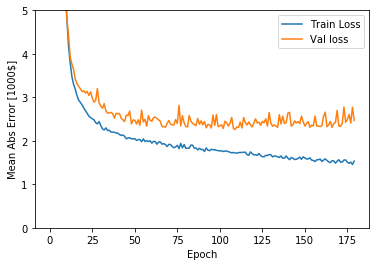

In [63]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement.
early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_data, train_labels, 
                    epochs=EPOCHS,
                    validation_split=0.2, 
                    verbose=0,
                    callbacks=[
                        early_stoper, 
                        PrintDot()
                    ])

plot_history(history)

The graph shows the average error is about \\$2,500 dollars. Is this good? Well, \\$2,500 is **not** an insignificant amount when some of the labels are only \\$15,000.

Let's see how did the model performs on the test set:

In [64]:
[loss, mae] = model.evaluate(test_data, test_labels, verbose=1)

print("Testing set Mean Abs Error: ${:7.2f}".format(mae * 1000))

102/102 [==============================] - 0s 51us/step
Testing set Mean Abs Error: $2785.35


## Predict

Finally, predict some housing prices using data in the testing set:

In [65]:
vect_of_result_vects = model.predict(test_data)
test_predictions = vect_of_result_vects.flatten()

print(test_predictions)

[ 9.375069 19.306358 21.538486 35.879196 25.260315 22.726273 27.018703
 22.602882 19.15848  24.326818 22.241247 16.350805 15.260238 42.76047
 20.970839 20.002422 25.988808 19.00184  21.051023 27.060188 12.528146
 16.997562 22.27104  17.26948  20.525408 25.509974 28.610552 32.075672
 11.867508 19.986736 20.4385   15.145944 32.876934 24.43221  19.803679
  8.987653 16.126057 17.450964 19.71431  26.04148  31.084486 26.86694
 15.403751 44.030262 28.427176 26.003668 27.839233 18.93174  25.31101
 23.084743 35.66707  21.610205 11.790237 16.122007 36.473614 27.942303
 13.580906 48.160404 33.90359  23.198565 26.11957  18.52772  15.59505
 20.441845 24.394974 21.346596 13.969278 21.920723 12.59387   8.612341
 26.654648 30.991503 28.003479 12.361489 25.14651  18.291132 19.55519
 24.793125 36.696987 11.159711 20.74458  36.78544  16.72489  14.504716
 18.083244 17.07031  23.764791 20.375446 21.190485 31.48234  21.144928
 20.43973  26.162418 43.66711  37.510685 21.63927  34.385075 48.724102
 25.929613 

## Conclusion

This notebook introduced a few techniques to handle a regression problem.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different than classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When input data features have values with different ranges, each feature should be scaled independently.
* If there is not much training data, prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.